## Import

In [144]:
import sys
sys.path.append(r'C:\Users\Marco\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\src\facility_location_Bergen\custome_modules')

In [3]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
# Ignore the ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [151]:
import io
import os
import copy
import pytz
import folium
import pyproj
import numpy as np
import pandas as pd
import pickle as pkl
import datetime as dt
from PIL import Image
import networkx as nx
from time import time
import geopandas as gpd
import cartopy.crs as ccrs
from datetime import datetime
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import cartopy.io.img_tiles as cimgt
from shapely.geometry import MultiPoint
from urllib.request import urlopen, Request
from matplotlib.animation import FuncAnimation
from mongo_db import retrieve_database_and_collections
from networkx.drawing.nx_agraph import graphviz_layout
from convert_geometry import toMultiLineString, toExtremePoints
from log import print_INFO_message_timestamp, print_INFO_message
from retrieve_global_parameters import retrieve_gdf_average_path
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString
from facility_location import AdjacencyMatrix, FacilityLocation, FacilityLocationReport

## Retrieve collection and convert to a dataframe

In [5]:
days = ["20_04_2023", "21_04_2023", "22_04_2023",
        "23_04_2023", "24_04_2023", "25_04_2023", 
        "26_04_2023", "27_04_2023", "28_04_2023",
        "29_04_2023", "30_04_2023"]

In [6]:
def get_gdf(day):
    with open(rf"C:\Users\Marco\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\data\03_primary\{day}_processed.geojson", "rb") as f:
        gdf = pkl.load(f)
    return gdf

In [7]:
gdfs = [get_gdf(day) for day in days]

## Create the average graph

### Take average value in each road segment for each gdf

In [53]:
def create_average_gdf(gdf):
   
   gdf["geometry_length"] = gdf["geometry_length"].apply(lambda x: tuple(x) if type(x) == list else tuple([x]))
   gdf_line = gdf.set_geometry("geometry.multi_line")
   gdf_point = gdf.set_geometry("geometry.extreme_point")
    
   gdf_line_average = gdf_line.groupby(["description", "currentFlow.traversability", "geometry_length", "geometry.multi_line"], sort=False, dropna=False)[
       ['length', 'currentFlow.speed', 'currentFlow.speedUncapped',
       'currentFlow.freeFlow', 'currentFlow.jamFactor',
       'currentFlow.confidence']].mean().reset_index()
    
   gdf_point_average = gdf_point.groupby(["description", "currentFlow.traversability", "geometry_length", "geometry.extreme_point"], sort=False, dropna=False)[
       ['length', 'currentFlow.speed', 'currentFlow.speedUncapped',
       'currentFlow.freeFlow', 'currentFlow.jamFactor',
       'currentFlow.confidence']].mean().reset_index()
    
   gdf_average = copy.deepcopy(gdf_point_average)
   gdf_average["geometry.multi_line"] = gdf_line_average["geometry.multi_line"]
    
   gdf_average = gdf_average[['description', 'currentFlow.traversability', 'geometry_length', 'geometry.extreme_point', 
                           'geometry.multi_line', 'length', 'currentFlow.speed', 'currentFlow.speedUncapped', 
                           'currentFlow.freeFlow','currentFlow.jamFactor', 'currentFlow.confidence',]]
    
   return gdf_average

In [196]:
gdf_average = [create_average_gdf(gdf) for gdf in gdfs]

##### Check for the presence of NaN values

In [198]:
print_INFO_message_timestamp("start")

for gdf in gdf_average:
   print_INFO_message(f"number of nan speed values: {gdf['currentFlow.speedUncapped'].isna().sum()}")

[05/10/23 11:22:12] INFO     start
                    INFO     number of nan speed values: 0
                    INFO     number of nan speed values: 0
                    INFO     number of nan speed values: 0
                    INFO     number of nan speed values: 0
                    INFO     number of nan speed values: 0
                    INFO     number of nan speed values: 0
                    INFO     number of nan speed values: 0
                    INFO     number of nan speed values: 0
                    INFO     number of nan speed values: 0
                    INFO     number of nan speed values: 0
                    INFO     number of nan speed values: 0


### Visualize the data

In [81]:
def image_spoof(self, tile): # this function pretends not to be a Python script
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

In [82]:
cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
osm_img = cimgt.OSM() # spoofed, downloaded street map

In [83]:
osm_img.crs

<Bound CRS: +proj=merc +a=6378137.0 +b=6378137.0 +nadgrids=@nu ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown to WGS84
- method: NTv2
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich
Source CRS: unknown

In [84]:
def get_color(jam, traversability):
    if jam is np.nan:
        return np.nan
    
    if traversability == "closed":
        return "black"
    
    if 0 <= jam <= 3:
        return "green"
    elif 3 < jam <= 7:
        return "orange"
    elif 7 <= jam <= 10:
        return "red"

In [129]:
def prepare_gdf_to_plot(gdf_average):
    lats = {}
    lons = {}
    df_list = []
    
    for feature, jam, traversability in zip(gdf_average['geometry.multi_line'], gdf_average["currentFlow.jamFactor"], gdf_average["currentFlow.traversability"]):
        color = get_color(jam, traversability)
        linestrings = feature.geoms
        lats = []
        lons = []
        colors = []
        
        for linestring in linestrings:
            x, y = linestring.xy
            lats = np.append(lats, list(x))
            lons = np.append(lons, list(y))
            colors = np.append(colors, [color]*len(x))
        
        df_list.append(pd.DataFrame({"lat": lats, "lon": lons, "color": colors}))
        df_list[-1] = pd.concat([df_list[-1], 
                                       pd.DataFrame({"lat": [np.nan], "lon": [np.nan], "color": [np.nan]})],
                                      ignore_index=True)

    df = pd.concat(df_list, ignore_index=True)
    return df

In [199]:
gdf_plot = [prepare_gdf_to_plot(gdf) for gdf in gdf_average]

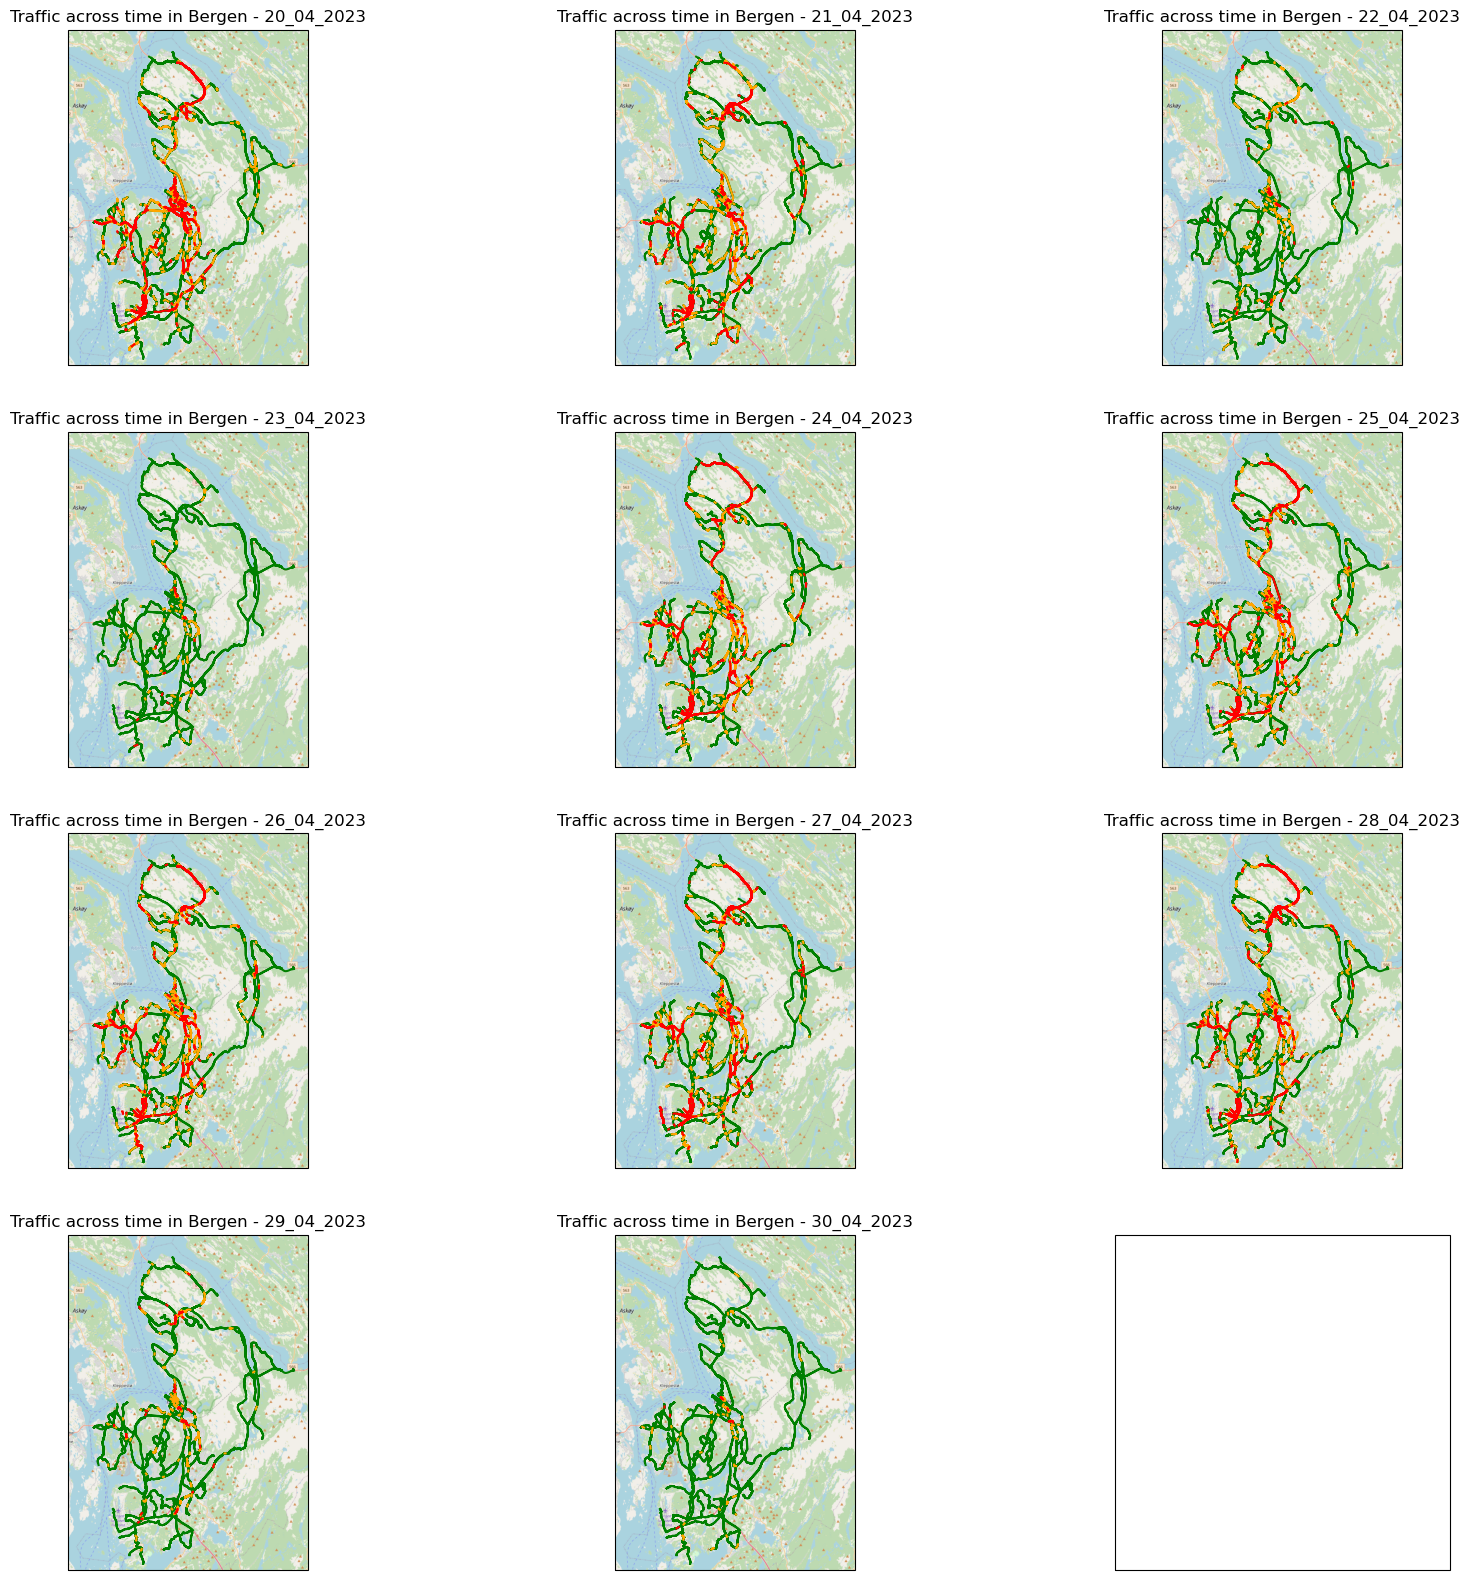

In [204]:
fig, ax = plt.subplots(figsize=(20, 20), ncols=3, nrows=4, subplot_kw={'projection': osm_img.crs})

for i, gdf in enumerate(gdf_plot):
    center_pt = [60.39299, 5.32415] # lat/lon of One World Trade Center in NYC
    zoom = 0.15 # for zooming out of center point
    extent = [center_pt[1]-(zoom*1.3),center_pt[1]+(zoom*1.6),center_pt[0]-zoom,center_pt[0]+zoom] # adjust to zoom
    
    if i < 3:
        j, k = 0, i
    elif i < 6:
        j, k = 1, i-3
    elif i < 9:
        j, k = 2, i-6
    else:
        j, k = 3, i-9

        
    ax[j,k].set_extent(extent) # set extents

    scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
    scale = (scale<20) and scale or 19 # scale cannot be larger than 19
    ax[j,k].add_image(osm_img, int(scale))

    ax[j,k].set_title(f'Traffic across time in Bergen - {days[i]}')

    ax[j,k].plot('lat', 'lon', data=gdf.where(gdf.color=="green"), c="green", transform=ccrs.Geodetic())
    ax[j,k].plot('lat', 'lon', data=gdf.where(gdf.color=="orange"), c="orange", transform=ccrs.Geodetic())
    ax[j,k].plot('lat', 'lon', data=gdf.where(gdf.color=="red"), c="red", transform=ccrs.Geodetic())


### Build the graph

In [122]:
def build_graph(gdf_average):
    G = nx.DiGraph()
    
    mapping = {}
    for j, col in enumerate(gdf_average.columns):
            mapping[col] = j
    
    for row in gdf_average.values:
        lines = pd.Series(row[mapping["geometry.multi_line"]])
        speed = row[mapping["currentFlow.speedUncapped"]]
        lengths = row[mapping["geometry_length"]]
        description = row[mapping["description"]]
    
        for i, line in enumerate(lines):
            p0 = toExtremePoints(line)[0]
            p1 = toExtremePoints(line)[-1]
            t0 = tuple([p0.coords.xy[0][0], p0.coords.xy[1][0]])
            t1 = tuple([p1.coords.xy[0][0], p1.coords.xy[1][0]])
        # if the road is closed, set the weight to a very high number
            if speed == 0:
                G.add_edge(t0, t1, weight=100000, description=description)
            else:
                G.add_edge(t0, t1, weight=lengths[i]/speed, description=description)
    return G

In [206]:
Gs = [build_graph(gdf) for gdf in gdf_average]

#### Strong connection

In [207]:
print_INFO_message_timestamp("strongly connected components")
for i, G in enumerate(Gs):
    print_INFO_message(f"{days[i]}: {nx.number_strongly_connected_components(G)}")

[05/10/23 11:34:42] INFO     strongly connected components
                    INFO     20_04_2023: 330
                    INFO     21_04_2023: 285
                    INFO     22_04_2023: 194
                    INFO     23_04_2023: 192
                    INFO     24_04_2023: 267
                    INFO     25_04_2023: 259
                    INFO     26_04_2023: 326
                    INFO     27_04_2023: 326
                    INFO     28_04_2023: 314
                    INFO     29_04_2023: 216
                    INFO     30_04_2023: 182


In [123]:
def build_strongly_cc(G):
    return [G.subgraph(c).copy() for c in sorted(nx.strongly_connected_components(G), reverse=True, key=len)]

In [209]:
CCs = [build_strongly_cc(G) for G in Gs]

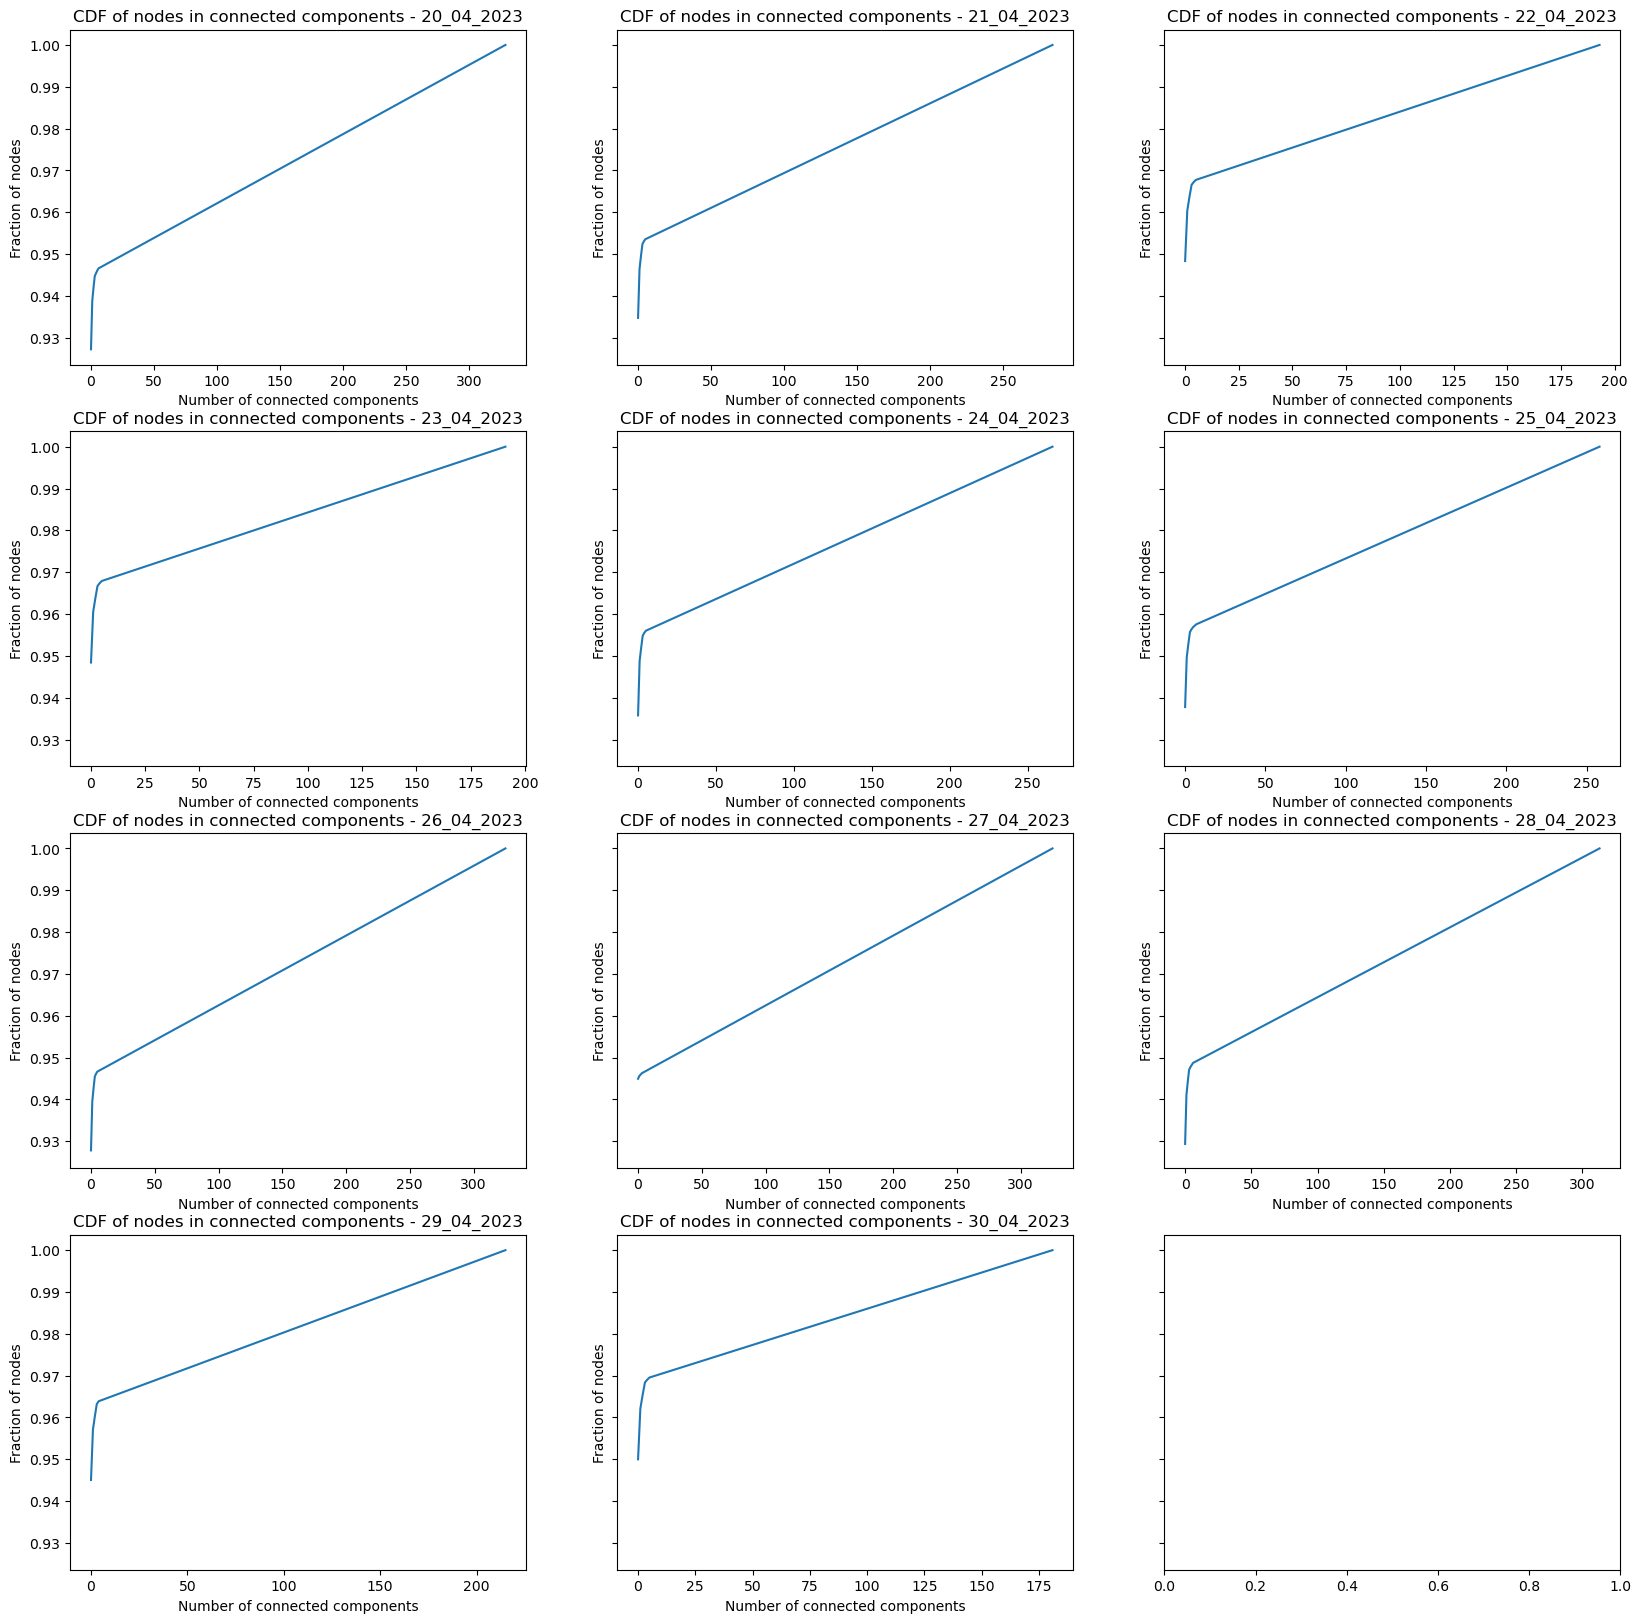

In [211]:
fig, ax = plt.subplots(figsize=(20, 20), ncols=3, nrows=4, sharey=True)

for i, CC in enumerate(CCs):
    n = 0
    l = []
    for j, cc in enumerate(CC):
        n+= cc.number_of_nodes()
        l.append(n/sum([cc.number_of_nodes() for cc in CC]))
        
    if i < 3:
        j, k = 0, i
    elif i < 6:
        j, k = 1, i-3
    elif i < 9:
        j, k = 2, i-6
    else:
        j, k = 3, i-9
        
    ax[j,k].plot(l)
    ax[j,k].set_title(f"CDF of nodes in connected components - {days[i]}")
    ax[j,k].set_xlabel("Number of connected components")
    ax[j,k].set_ylabel("Fraction of nodes")

In [215]:
print_INFO_message_timestamp("nodes number of the largest 4 components")

for i, CC in enumerate(CCs):
    print_INFO_message(f"{days[i]}: {[c.number_of_nodes() for c in CC[:4]]}")

[05/10/23 11:45:18] INFO     nodes number of the largest 4 components
                    INFO     20_04_2023: [5608, 70, 19, 17]
                    INFO     21_04_2023: [5616, 70, 19, 17]
                    INFO     22_04_2023: [5526, 70, 19, 17]
                    INFO     23_04_2023: [5496, 70, 19, 17]
                    INFO     24_04_2023: [5551, 77, 19, 17]
                    INFO     25_04_2023: [5545, 70, 19, 17]
                    INFO     26_04_2023: [5565, 70, 19, 17]
                    INFO     27_04_2023: [5663, 4, 2, 2]
                    INFO     28_04_2023: [5565, 70, 19, 17]
                    INFO     29_04_2023: [5522, 70, 19, 17]
                    INFO     30_04_2023: [5492, 70, 19, 17]


In [162]:
colors = ["red", "blue", "green", "orange"]

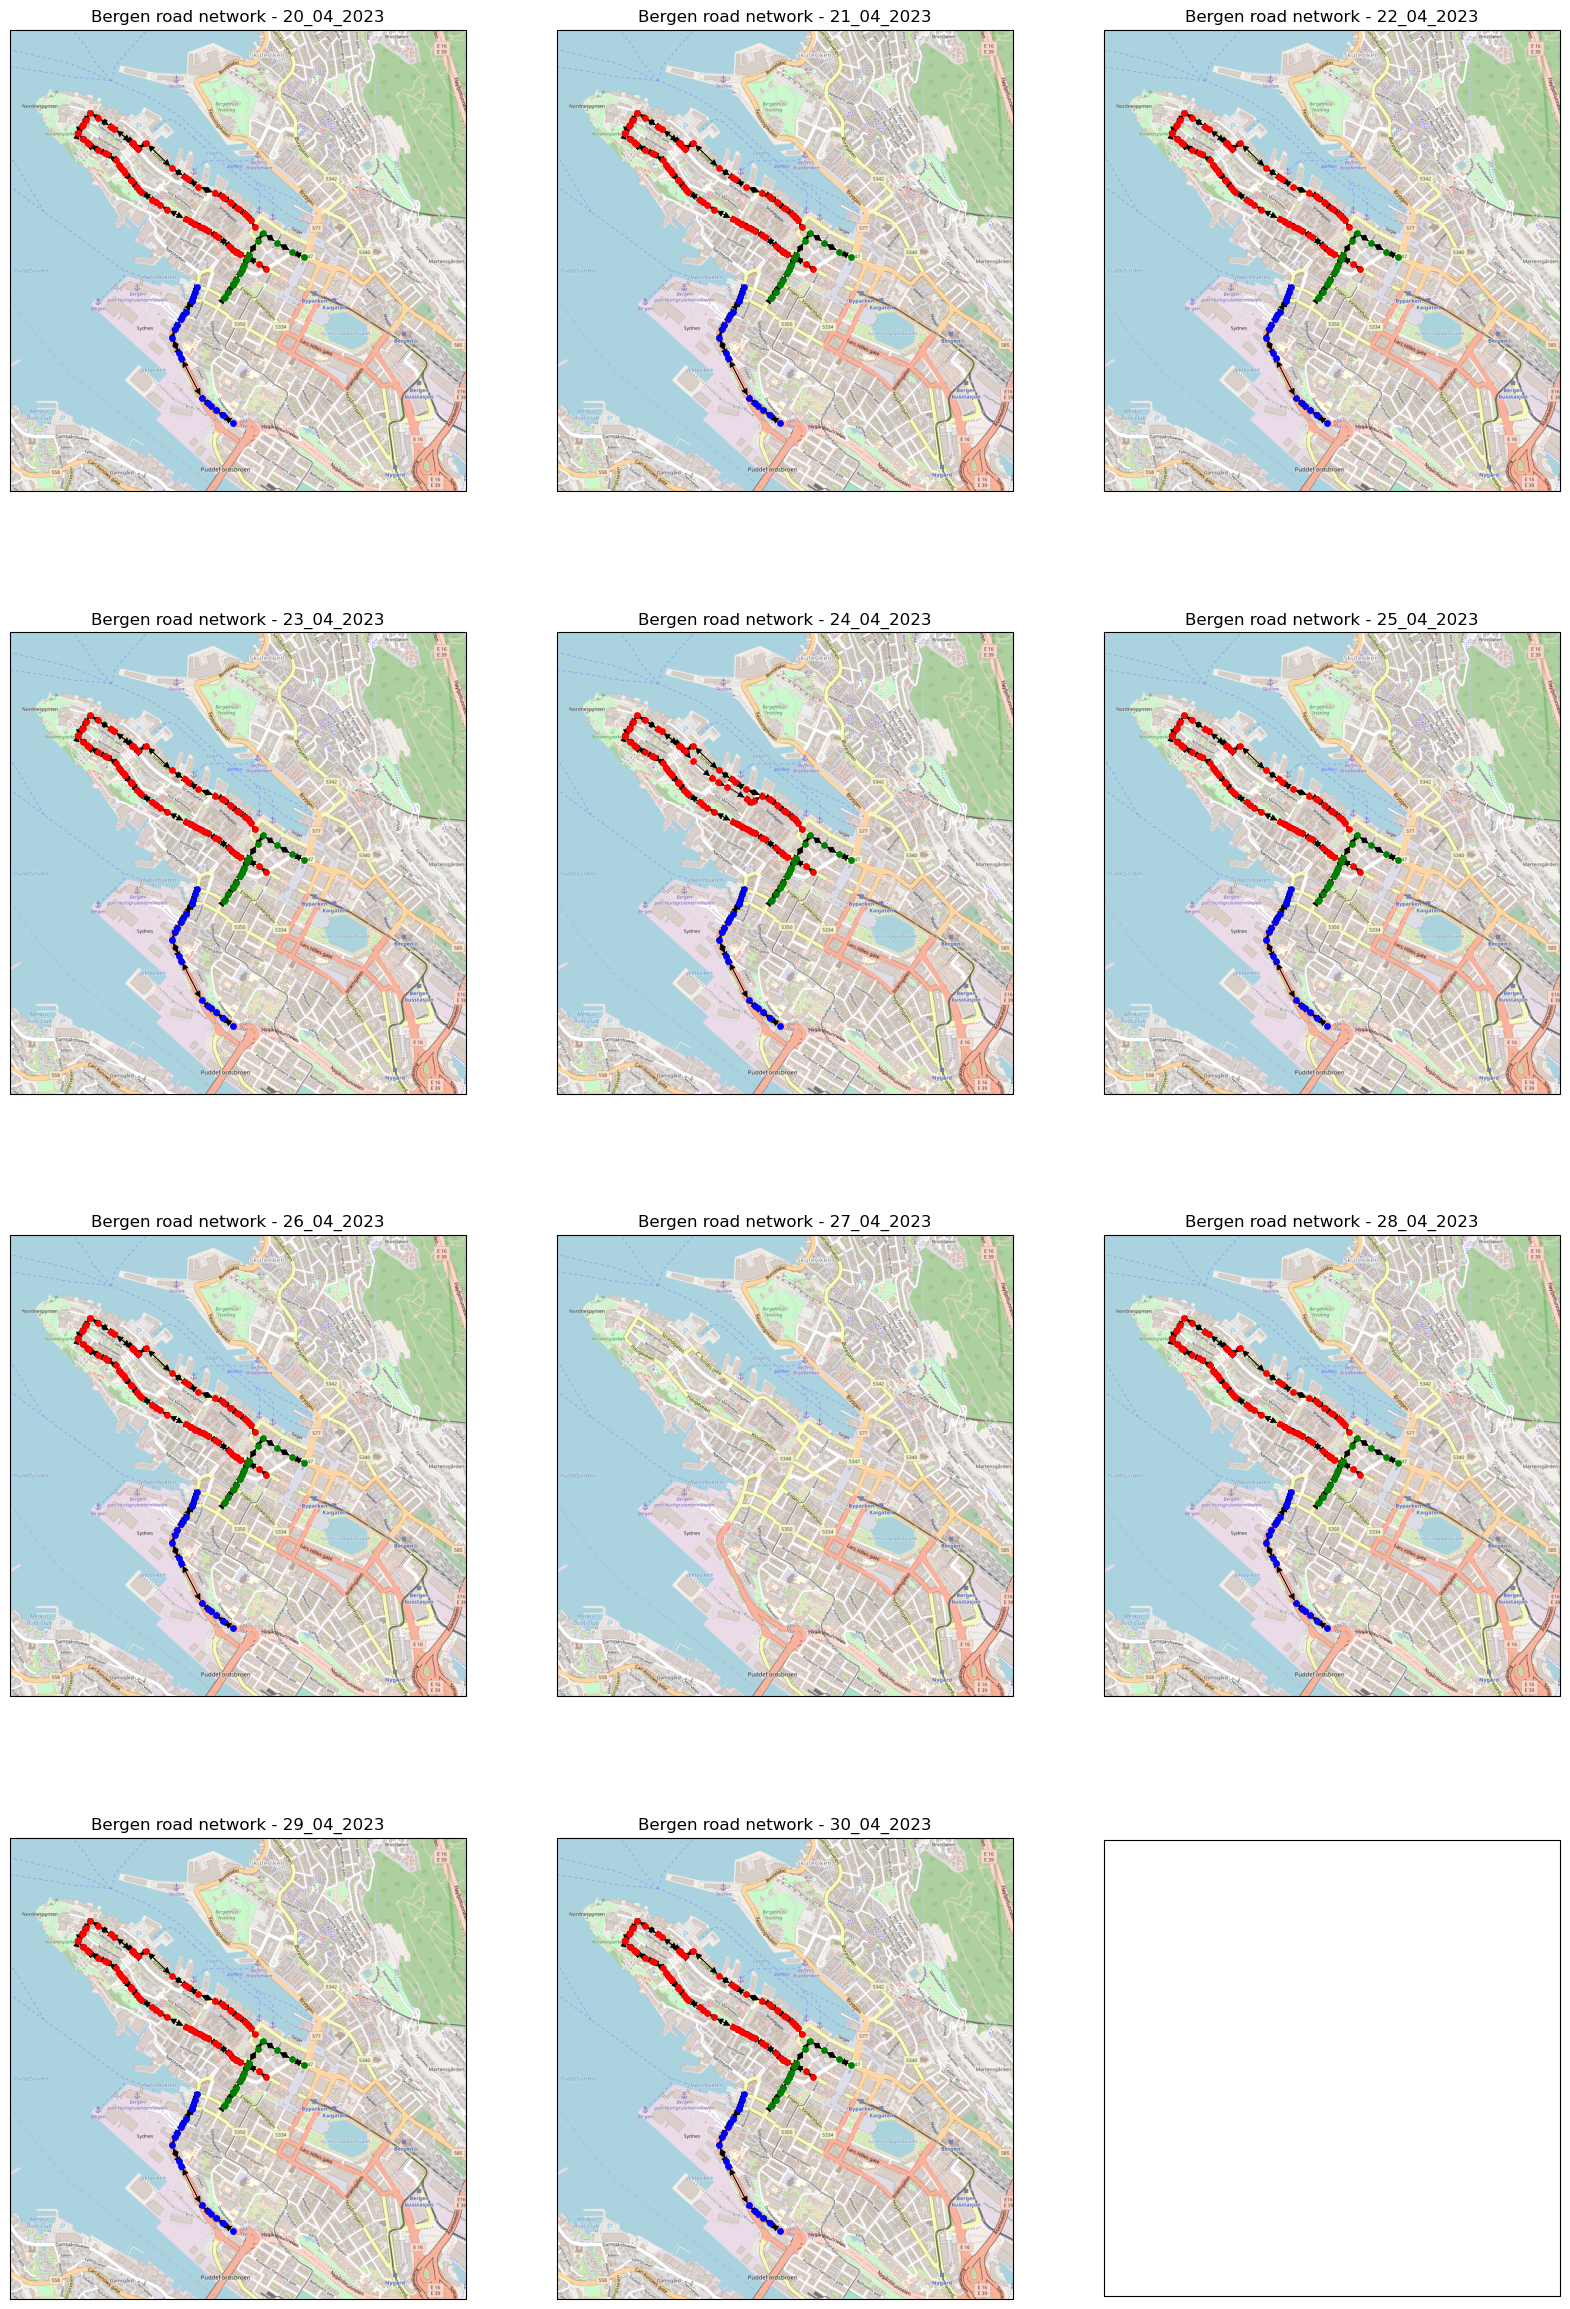

In [213]:
fig, ax = plt.subplots(figsize=(20, 30), ncols=3, nrows=4, subplot_kw={'projection': osm_img.crs})

for i, _ in enumerate(gdf_plot):
    # Define source CRS (WGS84)
    wgs84_crs = pyproj.CRS("EPSG:4326")
    # Create transformer object
    transformer = pyproj.Transformer.from_crs(wgs84_crs, osm_img.crs)
    # Transform coordinates
    pos = []
    for j in range(1, 4):
        pos.append({node : transformer.transform(node[1], node[0]) for node in CCs[i][j].nodes()})

    center_pt = [60.393472, 5.318841] # lat/lon of One World Trade Center in NYC
    zoom = 0.01 # for zooming out of center point
    extent = [center_pt[1]-(zoom*2),center_pt[1]+(zoom*2),center_pt[0]-zoom,center_pt[0]+zoom] # adjust to zoom
    
    if i < 3:
        j, k = 0, i
    elif i < 6:
        j, k = 1, i-3
    elif i < 9:
        j, k = 2, i-6
    else:
        j, k = 3, i-9
    
    ax[j,k].set_extent(extent) # set extents

    scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
    scale = (scale<20) and scale or 19 # scale cannot be larger than 19
    ax[j,k].add_image(osm_img, int(scale))

    for m in range(1, 4):
        nx.draw_networkx(CCs[i][m], pos=pos[m-1], 
                        node_size=15,
                        ax=ax[j,k],
                        width=0.5,
                        arrows=True,
                        with_labels = False,
                        node_color = colors[m-1])

    ax[j,k].set_title(f'Bergen road network - {days[i]}')

## Average graph across days

In [62]:
def get_time_gdf(gdf, time="morning"):
    first_morning_time = dt.time(5,30)
    last_morning_time = dt.time(7,30)
    first_midday_time = dt.time(9,0)
    last_midday_time = dt.time(10,0)
    first_afternoon_time = dt.time(13,0)
    last_afternoon_time = dt.time(15,0)
    
    if time == "morning":
        p1 = gdf["api_call_time"].dt.time >= first_morning_time
        p2 = gdf["api_call_time"].dt.time <= last_morning_time
        return gdf[p1 & p2]
    elif time == "midday":
        p1 = gdf["api_call_time"].dt.time >= first_midday_time
        p2 = gdf["api_call_time"].dt.time <= last_midday_time
        return gdf[p1 & p2]
    elif time == "afternoon":
        p1 = gdf["api_call_time"].dt.time >= first_afternoon_time
        p2 = gdf["api_call_time"].dt.time <= last_afternoon_time
        return gdf[p1 & p2]
    else:
        raise ValueError("time must be 'morning', 'midday' or 'afternoon'")
        

In [63]:
gdf = pd.concat(gdfs)

In [64]:
gdf_morning = get_time_gdf(gdf, time="morning")
gdf_midday = get_time_gdf(gdf, time="midday")
gdf_afternoon = get_time_gdf(gdf, time="afternoon")

In [65]:
def create_average_gdf(gdf):
   gdf = gdf[gdf["currentFlow.traversability"] == "open"]
   
   gdf["geometry_length"] = gdf["geometry_length"].apply(lambda x: tuple(x) if type(x) == list else tuple([x]))
   gdf_line = gdf.set_geometry("geometry.multi_line")
   gdf_point = gdf.set_geometry("geometry.extreme_point")
    
   gdf_line_average = gdf_line.groupby(["description", "geometry_length", "geometry.multi_line"], sort=False, dropna=False)[
       ['length', 'currentFlow.speed', 'currentFlow.speedUncapped',
       'currentFlow.freeFlow', 'currentFlow.jamFactor',
       'currentFlow.confidence']].mean().reset_index()
    
   gdf_point_average = gdf_point.groupby(["description", "geometry_length", "geometry.extreme_point"], sort=False, dropna=False)[
       ['length', 'currentFlow.speed', 'currentFlow.speedUncapped',
       'currentFlow.freeFlow', 'currentFlow.jamFactor',
       'currentFlow.confidence']].mean().reset_index()
    
   gdf_average = copy.deepcopy(gdf_point_average)
   gdf_average["geometry.multi_line"] = gdf_line_average["geometry.multi_line"]
    
   gdf_average = gdf_average[['description','geometry_length', 'geometry.extreme_point', 'geometry.multi_line', 
                              'length', 'currentFlow.speed', 'currentFlow.speedUncapped', 'currentFlow.freeFlow',
                              'currentFlow.jamFactor', 'currentFlow.confidence',]]
    
   return gdf_average

In [66]:
gdf_average = create_average_gdf(gdf)

C:\Users\Marco\AppData\Local\Temp\ipykernel_21028\1158712253.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf["geometry_length"] = gdf["geometry_length"].apply(lambda x: tuple(x) if type(x) == list else tuple([x]))


In [67]:
gdf_morning_average = create_average_gdf(gdf_morning)
gdf_midday_average = create_average_gdf(gdf_midday)
gdf_afternoon_average = create_average_gdf(gdf_afternoon)

C:\Users\Marco\AppData\Local\Temp\ipykernel_21028\1158712253.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf["geometry_length"] = gdf["geometry_length"].apply(lambda x: tuple(x) if type(x) == list else tuple([x]))
C:\Users\Marco\AppData\Local\Temp\ipykernel_21028\1158712253.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf["geometry_length"] = gdf["geometry_length"].apply(lambda x: tuple(x) if type(x) == list else tuple([x]))
C:\Users\Marco\AppData\Local\Temp\ipykernel_21028\1158712253.py:4: S

In [86]:
gdfs_average = {"all_day": gdf_average, "morning": gdf_morning_average, "midday": gdf_midday_average, "afternoon": gdf_afternoon_average}

In [87]:
for df in gdfs_average.values():
    print_INFO_message(f"shape: {df.shape}")

                    INFO     shape: (11001, 10)
                    INFO     shape: (5604, 10)
                    INFO     shape: (3092, 10)
                    INFO     shape: (7746, 10)


In [51]:
for df in gdfs:
    df = df.set_geometry("geometry.extreme_point")
    print_INFO_message("number of unique geometries: {}".format(df["geometry.extreme_point"].nunique()))

                    INFO     number of unique geometries: 3876
                    INFO     number of unique geometries: 3588
                    INFO     number of unique geometries: 1481
                    INFO     number of unique geometries: 1156
                    INFO     number of unique geometries: 3414
                    INFO     number of unique geometries: 3535
                    INFO     number of unique geometries: 3765
                    INFO     number of unique geometries: 3465
                    INFO     number of unique geometries: 3636
                    INFO     number of unique geometries: 1574
                    INFO     number of unique geometries: 1065


### Visualize the data

In [71]:
def image_spoof(self, tile): # this function pretends not to be a Python script
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

In [72]:
cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
osm_img = cimgt.OSM() # spoofed, downloaded street map

In [73]:
osm_img.crs

<Bound CRS: +proj=merc +a=6378137.0 +b=6378137.0 +nadgrids=@nu ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown to WGS84
- method: NTv2
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich
Source CRS: unknown

In [79]:
def get_color(jam):
    if jam is np.nan:
        return np.nan
    
    if 0 <= jam <= 3:
        return "green"
    elif 3 < jam <= 7:
        return "orange"
    elif 7 <= jam <= 10:
        return "red"

In [81]:
def prepare_gdf_to_plot(gdf_average):
    lats = {}
    lons = {}
    df_list = []
    
    for feature, jam in zip(gdf_average['geometry.multi_line'], gdf_average["currentFlow.jamFactor"]):
        color = get_color(jam)
        linestrings = feature.geoms
        lats = []
        lons = []
        colors = []
        
        for linestring in linestrings:
            x, y = linestring.xy
            lats = np.append(lats, list(x))
            lons = np.append(lons, list(y))
            colors = np.append(colors, [color]*len(x))
        
        df_list.append(pd.DataFrame({"lat": lats, "lon": lons, "color": colors}))
        df_list[-1] = pd.concat([df_list[-1], 
                                       pd.DataFrame({"lat": [np.nan], "lon": [np.nan], "color": [np.nan]})],
                                      ignore_index=True)

    df = pd.concat(df_list, ignore_index=True)
    return df

In [82]:
gdf_plot = [prepare_gdf_to_plot(df) for df in gdfs_average.values()]

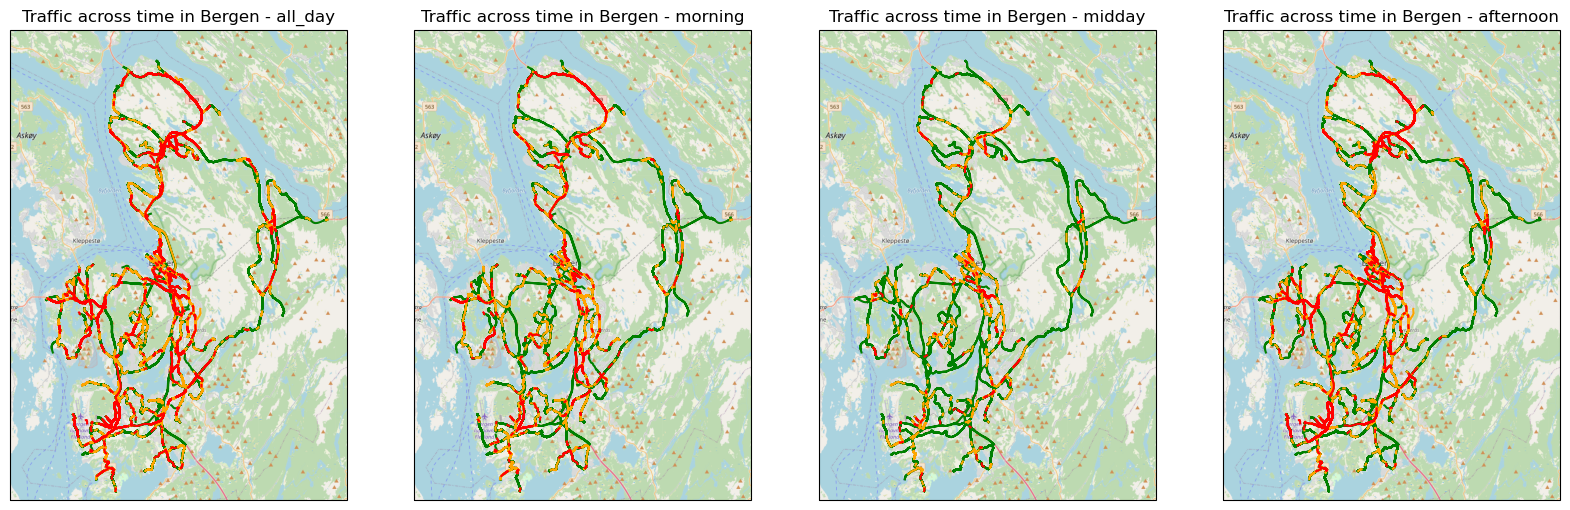

In [88]:
fig, ax = plt.subplots(figsize=(20, 20), ncols=4, nrows=1, subplot_kw={'projection': osm_img.crs})

for i, gdf in enumerate(gdf_plot):
    center_pt = [60.39299, 5.32415] # lat/lon of One World Trade Center in NYC
    zoom = 0.15 # for zooming out of center point
    extent = [center_pt[1]-(zoom*1.3),center_pt[1]+(zoom*1.6),center_pt[0]-zoom,center_pt[0]+zoom] # adjust to zoom
        
    ax[i].set_extent(extent) # set extents

    scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
    scale = (scale<20) and scale or 19 # scale cannot be larger than 19
    ax[i].add_image(osm_img, int(scale))

    ax[i].set_title(f'Traffic across time in Bergen - {list(gdfs_average.keys())[i]}')

    ax[i].plot('lat', 'lon', data=gdf.where(gdf.color=="green"), c="green", transform=ccrs.Geodetic())
    ax[i].plot('lat', 'lon', data=gdf.where(gdf.color=="orange"), c="orange", transform=ccrs.Geodetic())
    ax[i].plot('lat', 'lon', data=gdf.where(gdf.color=="red"), c="red", transform=ccrs.Geodetic())


### Keep only data common to all time periods

In [100]:
for df in gdfs_average.values():
    print_INFO_message(f"shape: {df.shape[0]-len(df['geometry.multi_line'].unique())}")

                    INFO     shape: 4
                    INFO     shape: 4
                    INFO     shape: 4
                    INFO     shape: 4


In [111]:
def merge_average_gdf(gdfs_average):
    keys = list(gdfs_average.keys())
    gdf_merge = gdfs_average[keys[0]][["description", "geometry_length", "geometry.extreme_point"]]\
        .merge(gdfs_average[keys[1]][["description", "geometry_length", "geometry.extreme_point"]],\
            how="inner", on=["description", "geometry_length", "geometry.extreme_point"])
    for i in range(2, len(keys)):
        try:
            gdf_merge = gdf_merge.merge(gdfs_average[keys[i]][["description", "geometry_length", "geometry.extreme_point"]],\
                how="inner", on=["description", "geometry_length", "geometry.extreme_point"])
        except:
            print_INFO_message(f"Could not merge {keys[i]}")
            return gdf_merge
    return gdf_merge

In [112]:
gdf_merge = merge_average_gdf(gdfs_average)

In [113]:
gdf_merge

description                                    geometry_length   
0            Herland   (21.0, 60.0, 26.0, 93.0, 14.0, 17.0, 79.0, 64.0)  \
1            Herland                          (134.0, 93.0, 26.0, 60.0)   
2             Takvam  (59.0, 33.0, 803.0, 66.0, 58.0, 40.0, 70.0, 33...   
3             Takvam                                       (19.0, 12.0)   
4             Takvam  (37.0, 52.0, 37.0, 15.0, 68.0, 13.0, 61.0, 21....   
...              ...                                                ...   
1675     Skulehaugen  (19.0, 385.0, 77.0, 123.0, 114.0, 19.0, 14.0, ...   
1676          Nygård                           (30.0, 16.0, 38.0, 40.0)   
1677    Busstasjonen               (56.0, 51.0, 19.0, 30.0, 48.0, 74.0)   
1678  Sædalstunnelen                                           (122.0,)   
1679  Sædalstunnelen  (22.0, 21.0, 23.0, 104.0, 183.0, 526.0, 83.0, ...   

                               geometry.extreme_point  
0     MULTIPOINT (5.53747 60.42335, 5.53903 60.42214)  
1     MULTIPOINT (5.53492 60.42177, 5.53757 60.42317)  
2     MULTIPOINT (5.53492 60.42177, 5.51596 60.42212)  
3     MULTIPOINT (5.51612 60.42207, 5.51624 60.42231)  
4     MULTIPOINT (5.46050 60.42195, 5.51596 60.42212)  
...                                               ...  
1675  MULTIPOINT (5.28823 60.34133, 5.28176 60.34838)  
1676  MULTIPOINT (5.29316 60.38782, 5.29176 60.38869)  
1677  MULTIPOINT (5.33387 60.38715, 5.33119 60.38925)  
1678  MULTIPOINT (5.38854 60.34512, 5.38667 60.34455)  
1679  MULTIPOINT (5.38667 60.34455, 5.36860 60.33965)  

[1680 rows x 3 columns]

In [114]:
gdfs_average_merged = {}

for key in gdfs_average.keys():
    gdfs_average_merged[key] = gdfs_average[key].merge(gdf_merge, how="inner", on=["description", "geometry_length", "geometry.extreme_point"])

### Visualize the data

In [158]:
gdfs_average_merged_path = ["c:/Users/Marco/Documents/GitHub/GeoSpatial-analysis/facility-location-Bergen/"+retrieve_gdf_average_path(key) 
                            for key in ["all_day", "morning", "midday", "afternoon"]]

In [157]:
gdfs_average_merged = [pkl.load(open(path, "rb")) for path in gdfs_average_merged_path]

In [160]:
gdf_plot = [prepare_gdf_to_plot(df) for df in gdfs_average_merged]

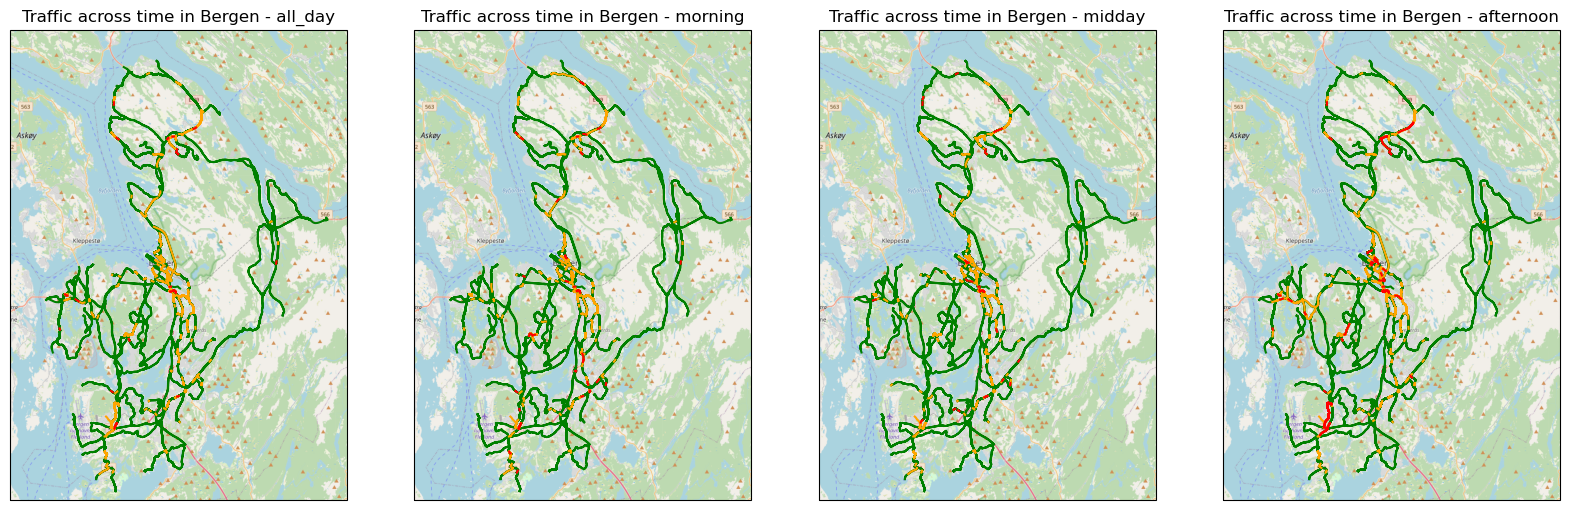

In [161]:
fig, ax = plt.subplots(figsize=(20, 20), ncols=4, nrows=1, subplot_kw={'projection': osm_img.crs})

for i, gdf in enumerate(gdf_plot):
    center_pt = [60.39299, 5.32415] # lat/lon of One World Trade Center in NYC
    zoom = 0.15 # for zooming out of center point
    extent = [center_pt[1]-(zoom*1.3),center_pt[1]+(zoom*1.6),center_pt[0]-zoom,center_pt[0]+zoom] # adjust to zoom
        
    ax[i].set_extent(extent) # set extents

    scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
    scale = (scale<20) and scale or 19 # scale cannot be larger than 19
    ax[i].add_image(osm_img, int(scale))

    ax[i].set_title(f'Traffic across time in Bergen - {["all_day", "morning", "midday", "afternoon"][i]}')

    ax[i].plot('lat', 'lon', data=gdf.where(gdf.color=="green"), c="green", transform=ccrs.Geodetic())
    ax[i].plot('lat', 'lon', data=gdf.where(gdf.color=="orange"), c="orange", transform=ccrs.Geodetic())
    ax[i].plot('lat', 'lon', data=gdf.where(gdf.color=="red"), c="red", transform=ccrs.Geodetic())


### Build the graph

In [163]:
Gs = [build_graph(gdf) for gdf in gdfs_average_merged]

#### Strong connection

In [164]:
print_INFO_message_timestamp("strongly connected components")
for i, G in enumerate(Gs):
    print_INFO_message(f"{days[i]}: {nx.number_strongly_connected_components(G)}")

[05/10/23 18:06:18] INFO     strongly connected components
                    INFO     20_04_2023: 183
                    INFO     21_04_2023: 183
                    INFO     22_04_2023: 183
                    INFO     23_04_2023: 183


In [126]:
def build_strongly_cc(G):
    return [G.subgraph(c).copy() for c in sorted(nx.strongly_connected_components(G), reverse=True, key=len)]

In [127]:
CCs = [build_strongly_cc(G) for G in Gs]

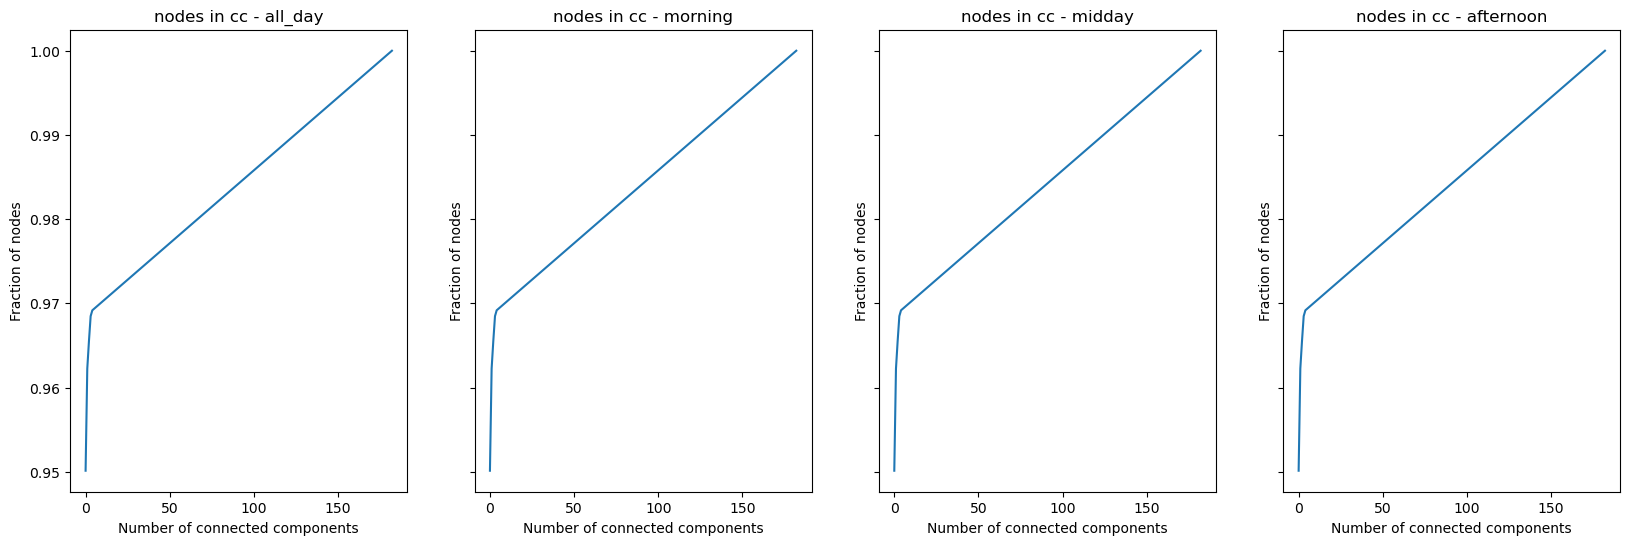

In [130]:
fig, ax = plt.subplots(figsize=(20, 6), ncols=4, nrows=1, sharey=True)

for i, CC in enumerate(CCs):
    n = 0
    l = []
    for j, cc in enumerate(CC):
        n+= cc.number_of_nodes()
        l.append(n/sum([cc.number_of_nodes() for cc in CC]))
        
    ax[i].plot(l)
    ax[i].set_title(f"nodes in cc - {list(gdfs_average_merged.keys())[i]}")
    ax[i].set_xlabel("Number of connected components")
    ax[i].set_ylabel("Fraction of nodes")

In [132]:
print_INFO_message_timestamp("nodes number of the largest 4 components")

for i, CC in enumerate(CCs):
    print_INFO_message(f"{days[i]}: {[c.number_of_nodes() for c in CC[:10]]}")

[05/10/23 15:52:19] INFO     nodes number of the largest 4 components
                    INFO     20_04_2023: [5486, 70, 19, 17, 4, 1, 1, 1, 1, 1]
                    INFO     21_04_2023: [5486, 70, 19, 17, 4, 1, 1, 1, 1, 1]
                    INFO     22_04_2023: [5486, 70, 19, 17, 4, 1, 1, 1, 1, 1]
                    INFO     23_04_2023: [5486, 70, 19, 17, 4, 1, 1, 1, 1, 1]


In [133]:
colors = ["red", "blue", "green", "orange"]

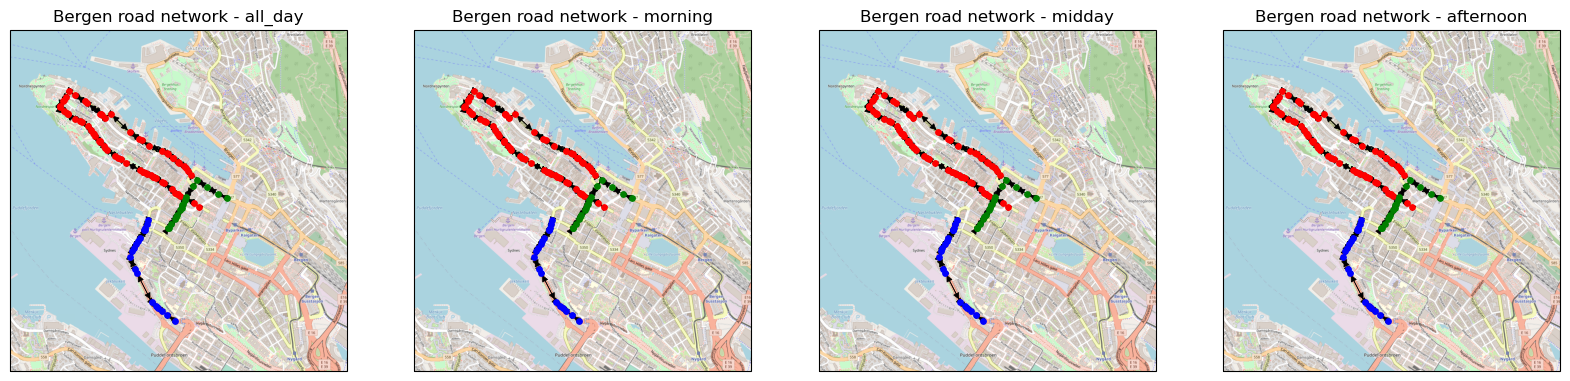

In [138]:
fig, ax = plt.subplots(figsize=(20, 30), ncols=4, nrows=1, subplot_kw={'projection': osm_img.crs})

for i, _ in enumerate(gdf_plot):
    # Define source CRS (WGS84)
    wgs84_crs = pyproj.CRS("EPSG:4326")
    # Create transformer object
    transformer = pyproj.Transformer.from_crs(wgs84_crs, osm_img.crs)
    # Transform coordinates
    pos = []
    for j in range(1, 4):
        pos.append({node : transformer.transform(node[1], node[0]) for node in CCs[i][j].nodes()})

    center_pt = [60.393472, 5.318841] 
    zoom = 0.01 # for zooming out of center point
    extent = [center_pt[1]-(zoom*2),center_pt[1]+(zoom*2),center_pt[0]-zoom,center_pt[0]+zoom] # adjust to zoom
    
    ax[i].set_extent(extent) # set extents

    scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
    scale = (scale<20) and scale or 19 # scale cannot be larger than 19
    ax[i].add_image(osm_img, int(scale))

    for m in range(1, 4):
        nx.draw_networkx(CCs[i][m], pos=pos[m-1], 
                        node_size=15,
                        ax=ax[i],
                        width=0.5,
                        arrows=True,
                        with_labels = False,
                        node_color = colors[m-1])

    ax[i].set_title(f'Bergen road network - {list(gdfs_average_merged.keys())[i]}')